In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [ ]:
D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

model = Model("V1Circuit", parameters)

### 2. Define eps function using Euler

In [ ]:
from epi.example_eps import V1_all_dr_eps
inc_val = 0.0
model.set_eps(V1_all_dr_eps(inc_val))

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_val, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(inc_val-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < inc_val+2*inc_std)

E, 0.01
E, 0.05


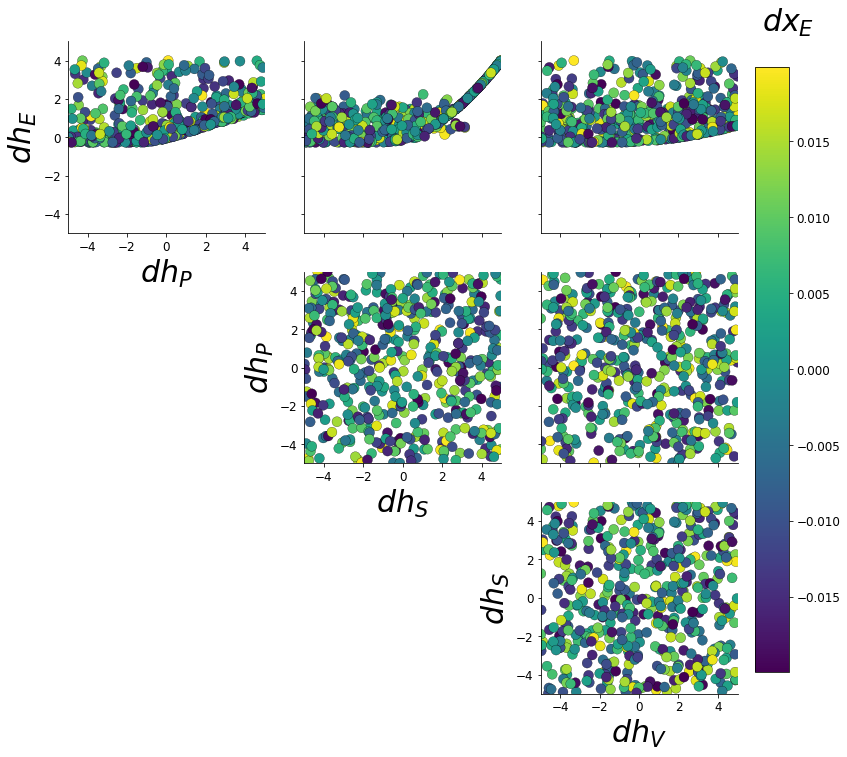

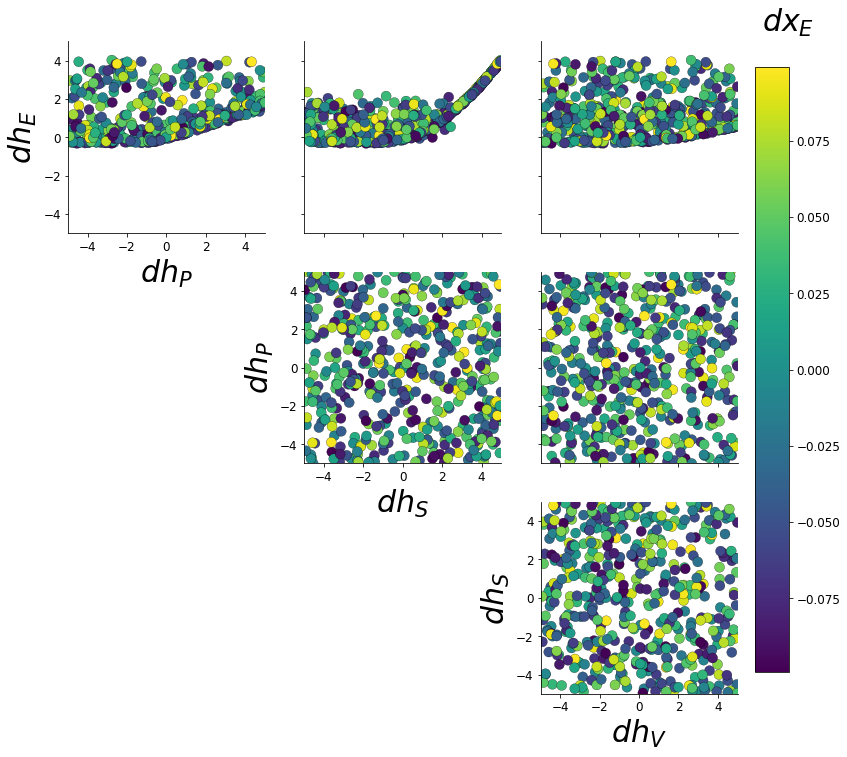

In [6]:
alphas = ['E']# 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = int(5e2)
num_plot = int(5e2)
M = 20000
zs = []
T_xs = []

inc_stds = [0.01, 0.05]
num_inc_std = len(inc_stds)

for k in range(num_inc_std):
    inc_std = inc_stds[k]
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        print('%s, %.2f' % (alpha, inc_std))
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        while (num_found < num_keep):
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()

            inds = accept_inds(_T_x, alpha, inc_val, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%d/%d\r' % (num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        negd = -np.square(T_x[:,neuron_ind])
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels,
                       fontsize=fontsize,
                       lb=lb, ub=ub,
                       c = T_x[:,neuron_ind],
                       c_label=r'$dx_%s$' % alpha)
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)

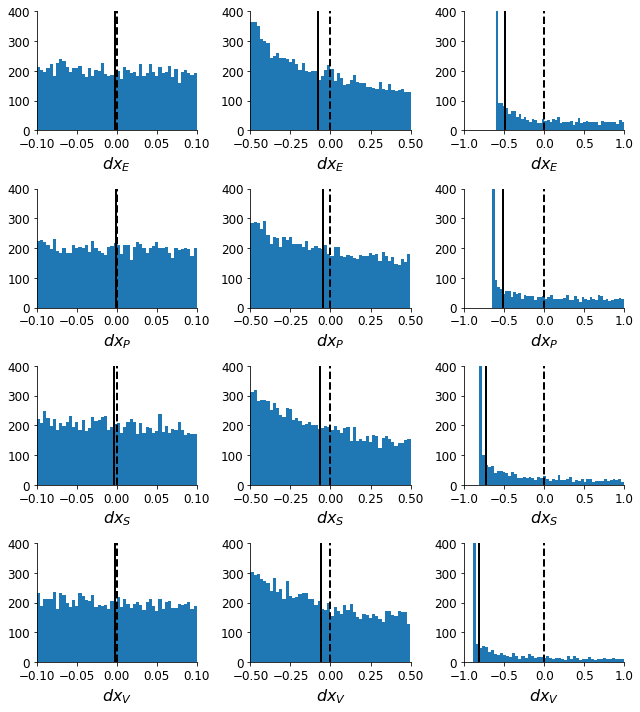

In [5]:
max_y = 400
fig, axs = plt.subplots(num_alphas, num_inc_std, figsize=(3*num_inc_std, 10))
for i in range(num_alphas):
    for j in range(num_inc_std):
        inc_std = inc_stds[j]
        ax = axs[i][j]
        alpha = alphas[i]
        dxi = T_xs[j][i][:,i]
        mean_dxi = np.mean(dxi)
        var_dxi = np.mean(dxi**2)
        ax.hist(dxi, bins=50, density=False)
        ax.plot([mean_dxi, mean_dxi], [0, max_y], 'k-')
        ax.plot([0, 0], [0, max_y], 'k--')
        ax.set_xlabel(r'$dx_%s$' % alpha)
        ax.set_xlim([-2*inc_std, 2*inc_std])
        ax.set_ylim([0, max_y])
        #ax.text(0.2*inc_std, 300, r'$E[dx_%s^2] = %.3f$' % (alpha, var_dxi), fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

Text(0, 0.5, '$x_\\alpha$')

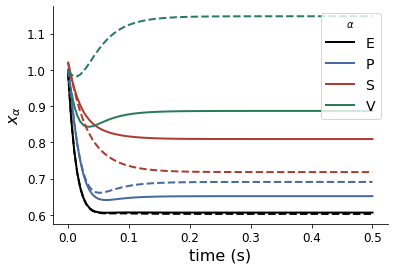

In [11]:
from epi.example_eps import V1_sim
alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
r_t1 = V1_sim(np.array([[0.0, 0.0, 0.0, 0.0]]), b=np.array([1., 1., 1., 1.25])).numpy()
r_t2 = V1_sim(np.array([[0.0, 0.0, 0.0, 0.1]]), b=np.array([1., 1., 1., 1.25])).numpy()
dt = np.arange(101)*0.005
for i in range(num_alphas):
    plt.plot(dt, r_t1[0,i,:].T, c=colors[i])
#plt.ylim([0, 1])
plt.legend(alphas, title=r'$\alpha$')
for i in range(num_alphas):
    plt.plot(dt, r_t2[0,i,:].T, '--', c=colors[i])

plt.xlabel('time (s)')
plt.ylabel(r'$x_\alpha$')